Рыцарев Игорь Андреевич

DST-37

Образование: аспирантура Самарского университета, 07.2021

e-mail: rycarev@gmail.com
tel: +7 (987) 446-76-09
    

Дано: набор данных об авиаперелетах за 2016-2017 года

(Схема БД представлена ниже)

Задача: проанализировать авиарейсы из Анапы за зиму 2017 и найти убыточные. Провести EDA.

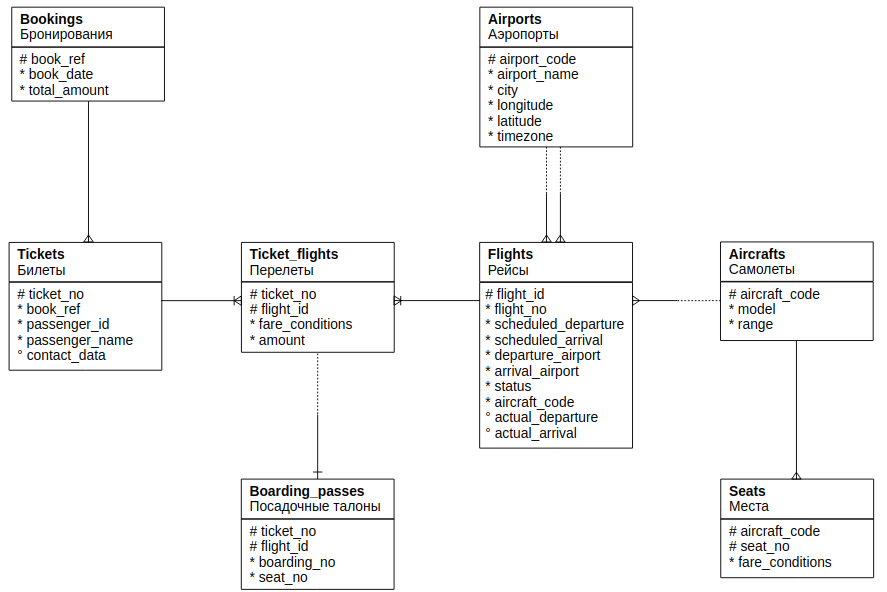

Для полноты данных дополнительно к данным за январь и февраль 2017 года добавим данные декабря 2016.
Итого имеем данные о 193 рейсах.

Для выгрузи из базы используем следующий SQL-запрос:

with 

    flight as (
        select
            *
        from
            dst_project.flights f 
        left join
            dst_project.aircrafts a on f.aircraft_code = a.aircraft_code
    ),
    
    ticket as (
    select
        tf.flight_id, 
        sum(tf.amount) sum_amount
    from
        dst_project.ticket_flights tf
    group by
        tf.flight_id
    ),
    
    ticket_count_by_class as (
        select
            tf.flight_id,
            count(case when tf.fare_conditions = 'Economy' then tf.fare_conditions end) as ticket_economy,
            count(case when tf.fare_conditions = 'Comfort' then tf.fare_conditions end) as ticket_comfort,
            count(case when tf.fare_conditions = 'Business' then tf.fare_conditions end) as ticket_business
        from dst_project.ticket_flights as tf
        group by tf.flight_id
    ),
    
    aircraft_seats as (
        select
            a.model,
            count(seat_no) all_seats
        from 
            dst_project.seats as s
        left join 
            dst_project.aircrafts a on s.aircraft_code = a.aircraft_code
       group by a.model
    ),
    /*
    distanse_between_airports as (
        select 
    		'SVO' arrival_airport,
    		1220 distance
    	union
        select 
    		'NOZ' arrival_airport,
    		3644  distance
    	union
        select 
    		'EGO' arrival_airport,
    		630  distance
    ),*/
    fuel_consumption as(
        select 
    		'Boeing 737-300' model,
    		2600 fuel_consumption
    	union
        select 
    		'Sukhoi Superjet-100' model,
    		1510  fuel_consumption
    )
    
select 

    f.flight_id,
    f.flight_no,
    f.scheduled_departure,
    f.departure_airport,
    f.arrival_airport,
    f.model,
    tcc.ticket_economy economy,
    tcc.ticket_comfort comfort,
    tcc.ticket_business business,
    aseats.all_seats,
    (aseats.all_seats - tcc.ticket_economy - tcc.ticket_comfort - tcc.ticket_business)*100. / aseats.all_seats procent_free_seats, 
    date_part('hour',f.scheduled_arrival - f.scheduled_departure)*60 + date_part('minutes',f.scheduled_arrival - f.scheduled_departure) scheduled_flight_time,
    date_part('hour',f.scheduled_arrival - f.scheduled_departure)*60 + date_part('minutes',f.scheduled_arrival - f.scheduled_departure) - date_part('hour',f.actual_arrival - f.actual_departure)*60 - date_part('minutes',f.actual_arrival - f.actual_departure) delta_flight_time,
    t.sum_amount,
    --dba. distance,
    --fc.fuel_consumption,
    --(date_part('hour',f.scheduled_arrival - f.scheduled_departure)*60 + date_part('minutes',f.scheduled_arrival - f.scheduled_departure))/60,
    --(date_part('hour',f.scheduled_arrival - f.scheduled_departure)*60 + date_part('minutes',f.scheduled_arrival - f.scheduled_departure))/60 * fc.fuel_consumption,
    (date_part('hour',f.scheduled_arrival - f.scheduled_departure)*60 + date_part('minutes',f.scheduled_arrival - f.scheduled_departure))/60 * fc.fuel_consumption * 40 fuel_cost,
    t.sum_amount - ((date_part('hour',f.scheduled_arrival - f.scheduled_departure)*60 + date_part('minutes',f.scheduled_arrival - f.scheduled_departure))/60 * fc.fuel_consumption * 40) profit

from flight f 

left join ticket t on t.flight_id = f.flight_id

left join ticket_count_by_class tcc on tcc.flight_id = f.flight_id

left join aircraft_seats aseats on aseats.model = f.model

/*left join distanse_between_airports dba on dba.arrival_airport = f.arrival_airport*/

left join fuel_consumption fc on f.model = fc.model

where 
    f.departure_airport = 'AAQ'
    and f.scheduled_departure >= '2016-12-01'
    and f.scheduled_departure < '2017-03-01'
    and not f.status = 'Cancelled'

На выходе из запроса мы получим данные о: 
* id рейса, 
* номере рейса, 
* запланированном времени вылета, 
* аэропорта вылета, 
* аэропорта назначения, 
* модели самолета, 
* количестве проданных билетов на данных рейс по классам (эконом, комфорт, бизнес), 
* общем числе мест на каждом самолете, проценте свободных мест на рейсе, 
* запланированном времени полета, 
* данные о задержках/досрочном прилете самолета, 
* общей стоимости проданных билетов, 
* стоимости затрат на топливо (по формуле: расход л/ч * время * стоимость топлива, данные о стоимости топлива для анапы в период 12.16-02.17 были взяты с сайта росавиации (https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm/) и усреднены до 40 руб/л), 
* профит рейса  

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

db = pd.read_csv('module4 db.csv', sep = ",")

In [20]:
#конвертируем столбец времени из object в datetime

db.scheduled_departure = pd.to_datetime(db.scheduled_departure)

In [18]:
db.head()

,flight_id,flight_no,scheduled_departure,departure_airport,arrival_airport,model,economy,comfort,business,all_seats,procent_free_seats,scheduled_flight_time,delta_flight_time,sum_amount,fuel_cost,profit
0,136119,PG0252,2017-01-03T10:05:00Z,AAQ,SVO,Boeing 737-300,102.0,0.0,11.0,130,13.076923,100.0,-1.0,1653000.0,173333.333333,1.479667e+06
1,136120,PG0252,2017-02-24T10:05:00Z,AAQ,SVO,Boeing 737-300,98.0,0.0,11.0,130,16.153846,100.0,1.0,1605400.0,173333.333333,1.432067e+06
2,136122,PG0252,2017-01-08T10:05:00Z,AAQ,SVO,Boeing 737-300,87.0,0.0,10.0,130,25.384615,100.0,0.0,1431000.0,173333.333333,1.257667e+06
3,136130,PG0252,2017-02-13T10:05:00Z,AAQ,SVO,Boeing 737-300,97.0,0.0,10.0,130,17.692308,100.0,1.0,1556600.0,173333.333333,1.383267e+06
4,136131,PG0252,2017-01-28T10:05:00Z,AAQ,SVO,Boeing 737-300,112.0,0.0,12.0,130,4.615385,100.0,1.0,1812800.0,173333.333333,1.639467e+06


In [21]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   flight_id              193 non-null    int64              
 1   flight_no              193 non-null    object             
 2   scheduled_departure    193 non-null    datetime64[ns, UTC]
 3   departure_airport      193 non-null    object             
 4   arrival_airport        193 non-null    object             
 5   model                  193 non-null    object             
 6   economy                180 non-null    float64            
 7   comfort                180 non-null    float64            
 8   business               180 non-null    float64            
 9   all_seats              193 non-null    int64              
 10  procent_free_seats     180 non-null    float64            
 11  scheduled_flight_time  193 non-null    float64            

Проведем первичный анализ

In [23]:
db.flight_id.value_counts()

136961    1
136324    1
136612    1
136869    1
136871    1
         ..
136282    1
136793    1
136284    1
136936    1
136447    1
Name: flight_id, Length: 193, dtype: int64

Колонка flight_id содержит уникальные индентификаторы каждого аолета самолета
Ценность -> 0

In [24]:
db.flight_no.value_counts()

PG0480    90
PG0252    90
PG0194    13
Name: flight_no, dtype: int64

Колонка flight_no содержит в себе номера рейсов.
Совпадает с аэропортами назначения (arrival_airport):
* PG0480 = EGO
* PG0252 = SVO
* PG0194 = NOZ

Целесообразно провести анализ по каждому аэропорту отдельно (EGO, SVO). Анализ по аэропорту NOZ невозможен ввиду пропусков в данных по выручке от проданных билетов.

In [25]:
db.model.value_counts()

Boeing 737-300         103
Sukhoi Superjet-100     90
Name: model, dtype: int64

В выборке представлены только две модели самолетов Boeing 737-300 (733) (SVO, NOZ) и Sukhoi Superjet-100 (SU9) (EGO)

Подготовим набор данных по аэропортам:

In [88]:
db_svo = db[db.arrival_airport == "SVO"]
db_svo = db_svo.sort_values('scheduled_departure')

db_ego = db[db.arrival_airport == "EGO"]
db_ego = db_ego.sort_values('scheduled_departure')

# Москва

In [28]:
db_svo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 89
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   flight_id              90 non-null     int64              
 1   flight_no              90 non-null     object             
 2   scheduled_departure    90 non-null     datetime64[ns, UTC]
 3   departure_airport      90 non-null     object             
 4   arrival_airport        90 non-null     object             
 5   model                  90 non-null     object             
 6   economy                90 non-null     float64            
 7   comfort                90 non-null     float64            
 8   business               90 non-null     float64            
 9   all_seats              90 non-null     int64              
 10  procent_free_seats     90 non-null     float64            
 11  scheduled_flight_time  90 non-null     float64            
 

Подготовим набор данных по средним значениям по дням недели

In [78]:
week_db_svo = db_svo.groupby(db_svo['scheduled_departure'].dt.weekday).mean()
week_db_svo

,flight_id,economy,comfort,business,all_seats,procent_free_seats,scheduled_flight_time,delta_flight_time,sum_amount,fuel_cost,profit
scheduled_departure,,,,,,,,,,,
0,136310.538462,104.384615,0.0,10.384615,130.0,11.715976,100.0,-0.230769,1.660031e+06,173333.333333,1.486697e+06
1,136299.846154,105.230769,0.0,10.461538,130.0,11.005917,100.0,-0.230769,1.672615e+06,173333.333333,1.499282e+06
2,136251.000000,101.250000,0.0,10.500000,130.0,14.038462,100.0,0.083333,1.624850e+06,173333.333333,1.451517e+06
3,136317.538462,105.461538,0.0,10.615385,130.0,10.710059,100.0,-0.230769,1.681431e+06,173333.333333,1.508097e+06
4,136364.923077,107.769231,0.0,11.000000,130.0,8.639053,100.0,0.538462,1.724031e+06,173333.333333,1.550697e+06
5,136305.615385,100.000000,0.0,10.846154,130.0,14.733728,100.0,0.000000,1.623523e+06,173333.333333,1.450190e+06
6,136300.769231,96.230769,0.0,9.846154,130.0,18.402367,100.0,0.307692,1.540108e+06,173333.333333,1.366774e+06


Построим график заполняемости самолетов в зависимости от дня недели по неделям

/home/hotf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


WeekNo         1          2          3          4          5          6   \
0       15.384615  23.076923  18.461538  12.307692   0.000000  16.923077   
1       13.076923   0.769231   7.692308  16.923077   9.230769  10.000000   
2       11.538462  20.769231   0.769231  18.461538  11.538462  23.846154   
3       23.076923   0.000000   6.923077   4.615385  17.692308  16.153846   
4       13.846154   3.846154   6.153846  18.461538   1.538462   7.692308   
5        7.692308  20.000000  11.538462   4.615385  15.384615  16.153846   
6       25.384615  15.384615  10.000000  23.846154  25.384615  14.615385   

WeekNo         7          8          9          48         49         50  \
0       17.692308   0.769231  16.923077        NaN   9.230769  16.153846   
1        5.384615   6.153846  12.307692        NaN  17.692308   6.923077   
2       10.769231  15.384615        NaN        NaN  25.384615  19.230769   
3       11.538462  17.692308        NaN   0.769231  20.769231   0.000000   
4       16.

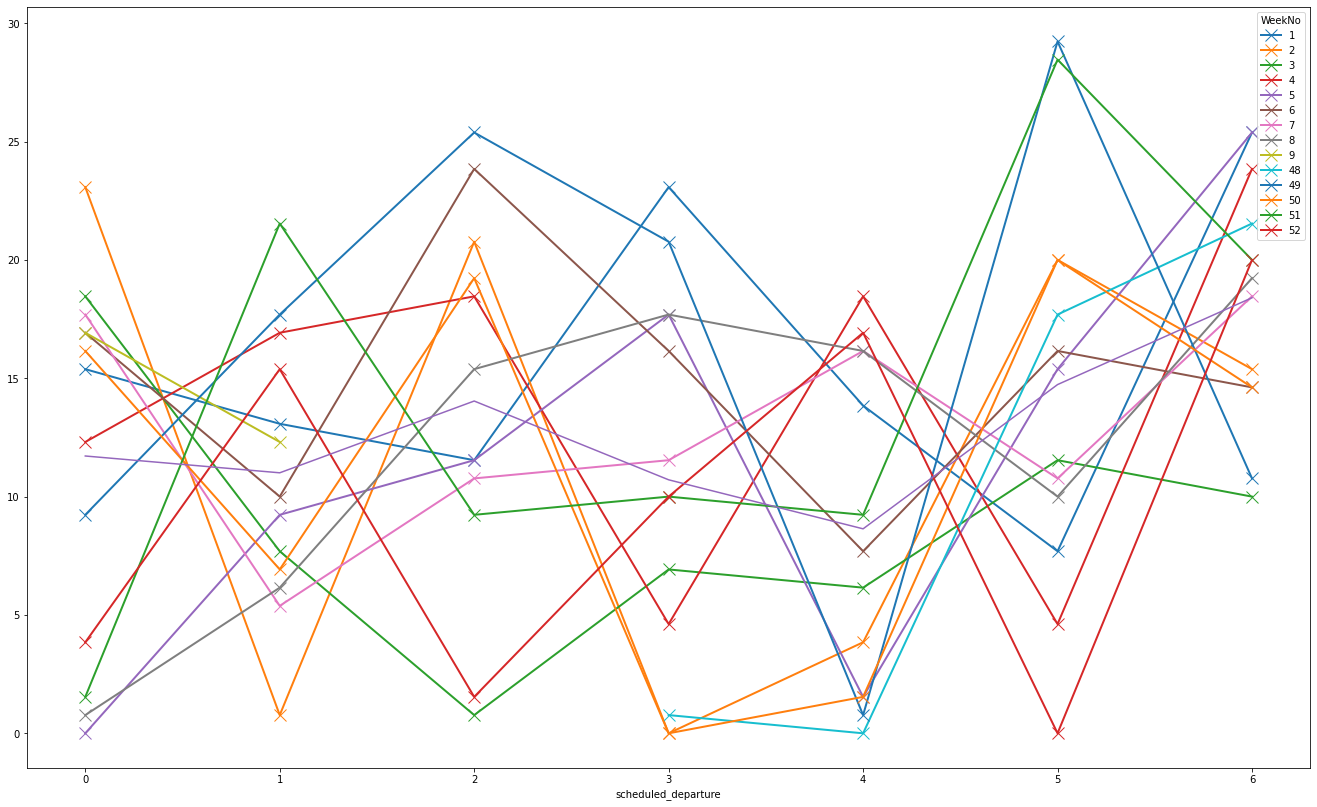

In [66]:
reshaped = (db_svo
            .assign(date=lambda f: pd.to_datetime(f.scheduled_departure))
            .assign(dayofweek=lambda f: f.scheduled_departure.dt.weekday, 
                    WeekNo=lambda f: f.scheduled_departure.dt.week)
            .assign(mean = lambda f: f.procent_free_seats)
            .set_index(['dayofweek', 'WeekNo'])
            .procent_free_seats
            .unstack()
            .reset_index(0, drop=True))

print(reshaped)

plt = reshaped.plot(marker='x', linewidth=2, markersize=12, figsize=(23,14))


А теперь посмотрим график средней загруженности самолетов по дням недели

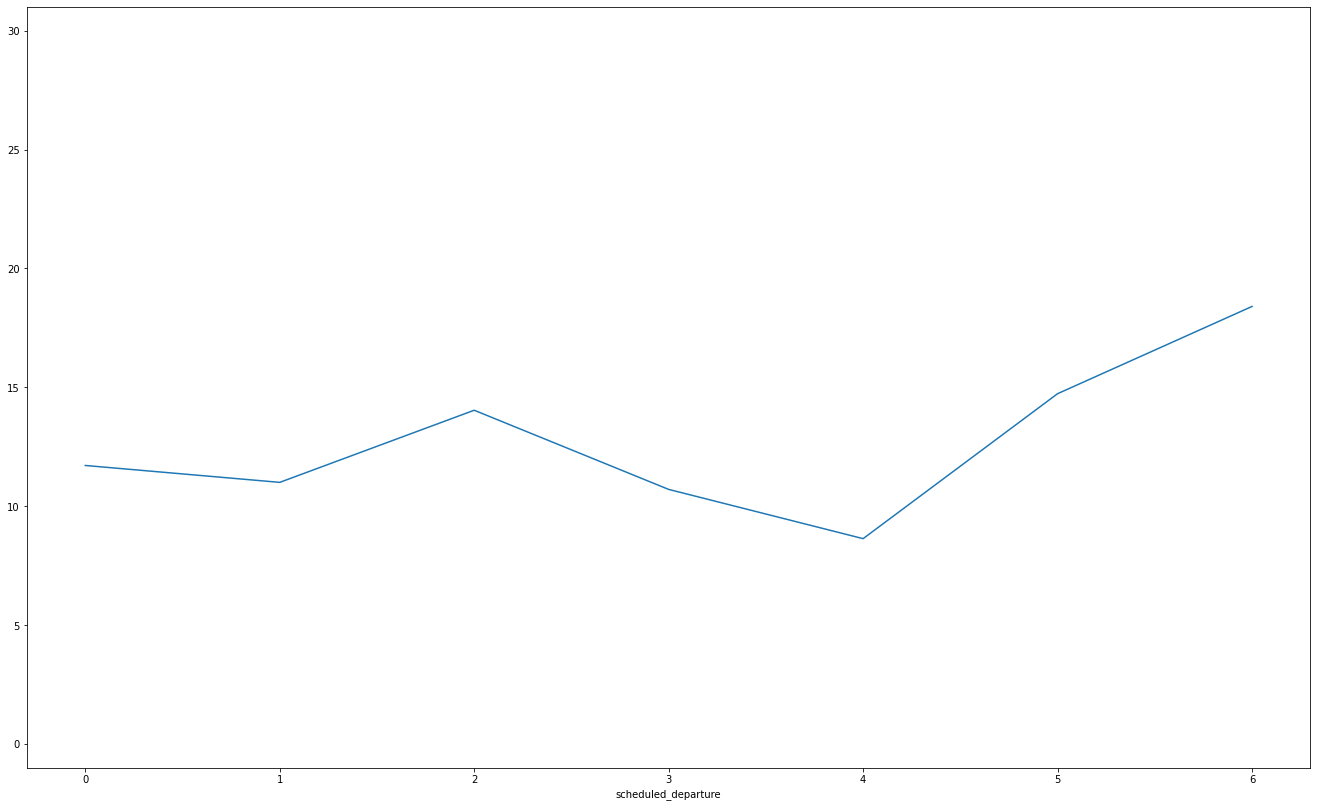

In [79]:
plt_mean = week_db_svo.procent_free_seats.plot(figsize=(23,14)).set_ylim(-1, 31)

Как видно из графиков, наибольшая наполняемость рейсов происходит по четвергам (8% свободных мест), а наименьшая по субботам (18%). Так же загруженность на уровне (15%) присутствует по пятницам и вторникам.

Оценим прибыль по дням недели

/home/hotf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


WeekNo         1          2          3          4          5          6   \
0       15.384615  23.076923  18.461538  12.307692   0.000000  16.923077   
1       13.076923   0.769231   7.692308  16.923077   9.230769  10.000000   
2       11.538462  20.769231   0.769231  18.461538  11.538462  23.846154   
3       23.076923   0.000000   6.923077   4.615385  17.692308  16.153846   
4       13.846154   3.846154   6.153846  18.461538   1.538462   7.692308   
5        7.692308  20.000000  11.538462   4.615385  15.384615  16.153846   
6       25.384615  15.384615  10.000000  23.846154  25.384615  14.615385   

WeekNo         7          8          9          48         49         50  \
0       17.692308   0.769231  16.923077        NaN   9.230769  16.153846   
1        5.384615   6.153846  12.307692        NaN  17.692308   6.923077   
2       10.769231  15.384615        NaN        NaN  25.384615  19.230769   
3       11.538462  17.692308        NaN   0.769231  20.769231   0.000000   
4       16.

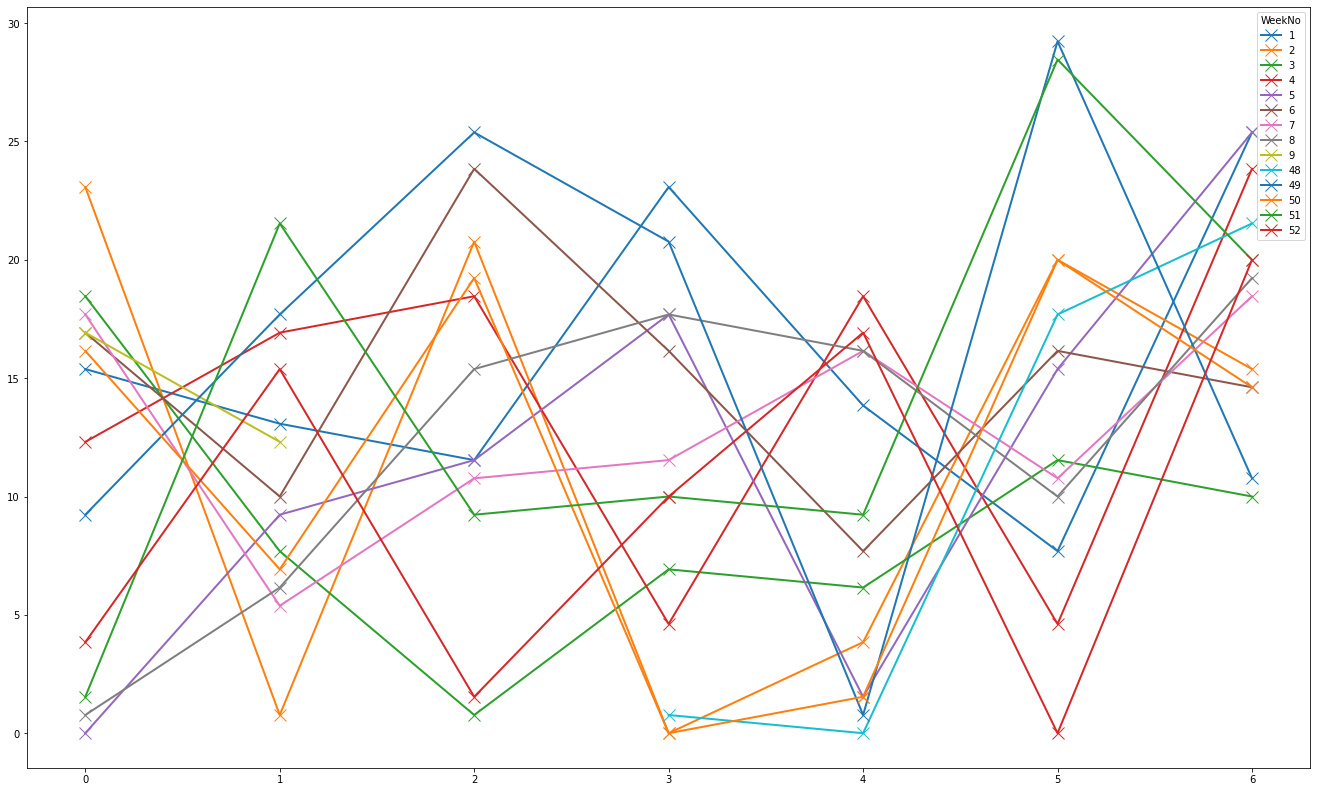

In [103]:
reshaped = (db_svo
            .assign(date=lambda f: pd.to_datetime(f.scheduled_departure))
            .assign(dayofweek=lambda f: f.scheduled_departure.dt.weekday, 
                    WeekNo=lambda f: f.scheduled_departure.dt.week)
            .assign(mean = lambda f: f.procent_free_seats)
            .set_index(['dayofweek', 'WeekNo'])
            .procent_free_seats
            .unstack()
            .reset_index(0, drop=True))

print(reshaped)

plt = reshaped.plot(marker='x', linewidth=2, markersize=12, figsize=(23,14))


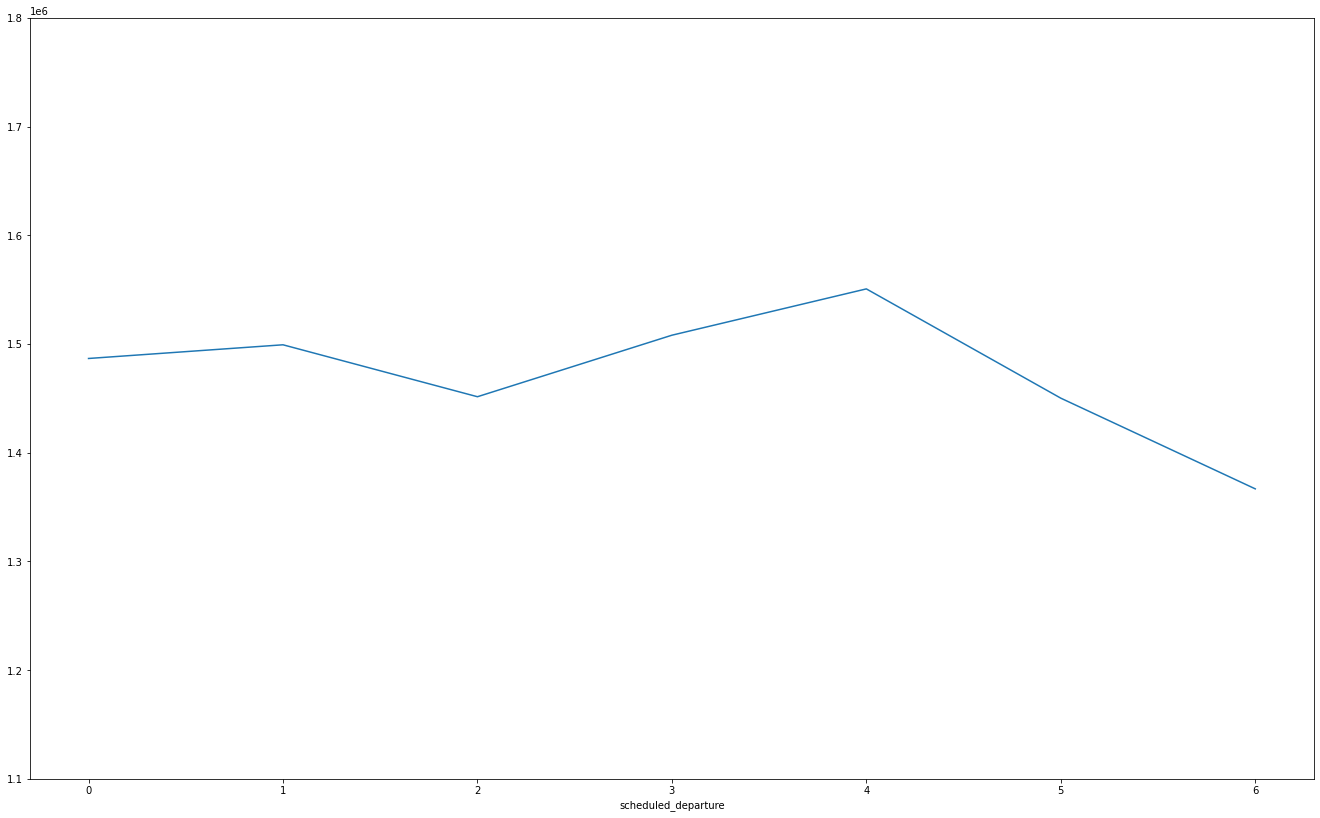

In [84]:
plt_mean = week_db_svo.profit.plot(figsize=(23,14)).set_ylim(1.1*1e6, 1.8*1e6)

Прибыль напрямую связана с количеством пассажиров что подтверждено графиками.

Сделаем аналогичное сравнение для Белгорода  

# Белгород

In [89]:
db_ego.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 129 to 165
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   flight_id              90 non-null     int64              
 1   flight_no              90 non-null     object             
 2   scheduled_departure    90 non-null     datetime64[ns, UTC]
 3   departure_airport      90 non-null     object             
 4   arrival_airport        90 non-null     object             
 5   model                  90 non-null     object             
 6   economy                90 non-null     float64            
 7   comfort                90 non-null     float64            
 8   business               90 non-null     float64            
 9   all_seats              90 non-null     int64              
 10  procent_free_seats     90 non-null     float64            
 11  scheduled_flight_time  90 non-null     float64           

Подготовим набор данных по средним значениям по дням недели

In [91]:
week_db_ego = db_ego.groupby(db_ego['scheduled_departure'].dt.weekday).mean()
week_db_ego

,flight_id,economy,comfort,business,all_seats,procent_free_seats,scheduled_flight_time,delta_flight_time,sum_amount,fuel_cost,profit
scheduled_departure,,,,,,,,,,,
0,136805.230769,78.000000,0.0,10.846154,97.0,8.406027,50.0,0.076923,699161.538462,50333.333333,648828.205128
1,136763.307692,79.307692,0.0,10.846154,97.0,7.057891,50.0,-0.076923,707400.000000,50333.333333,657066.666667
2,136773.416667,83.500000,0.0,11.833333,97.0,1.718213,50.0,-0.083333,752700.000000,50333.333333,702366.666667
3,136742.000000,79.615385,0.0,11.076923,97.0,6.502776,50.0,0.153846,713792.307692,50333.333333,663458.974359
4,136771.153846,78.538462,0.0,11.076923,97.0,7.613006,50.0,0.076923,707053.846154,50333.333333,656720.512821
5,136793.846154,78.769231,0.0,11.000000,97.0,7.454401,50.0,-0.076923,706684.615385,50333.333333,656351.282051
6,136767.538462,78.153846,0.0,11.000000,97.0,8.088818,50.0,-0.153846,703084.615385,50333.333333,652751.282051


Построим график заполняемости самолетов в зависимости от дня недели по неделям

/home/hotf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


WeekNo         1          2          3          4          5          6   \
0       15.463918   3.092784   1.030928  14.432990  34.020619   7.216495   
1       16.494845   1.030928   2.061856  11.340206   0.000000   0.000000   
2        1.030928  10.309278   1.030928   2.061856   0.000000   0.000000   
3       15.463918   0.000000   1.030928   2.061856   7.216495  10.309278   
4        2.061856   0.000000  19.587629   0.000000   1.030928   9.278351   
5        6.185567   0.000000   0.000000  17.525773   1.030928  21.649485   
6       16.494845  10.309278   0.000000   9.278351  19.587629  10.309278   

WeekNo         7          8          9          48         49         50  \
0        0.000000  10.309278   0.000000        NaN   3.092784  10.309278   
1       18.556701   3.092784  18.556701        NaN   0.000000  10.309278   
2        0.000000   1.030928        NaN        NaN   1.030928   0.000000   
3        0.000000  29.896907        NaN   3.092784   0.000000   8.247423   
4       18.

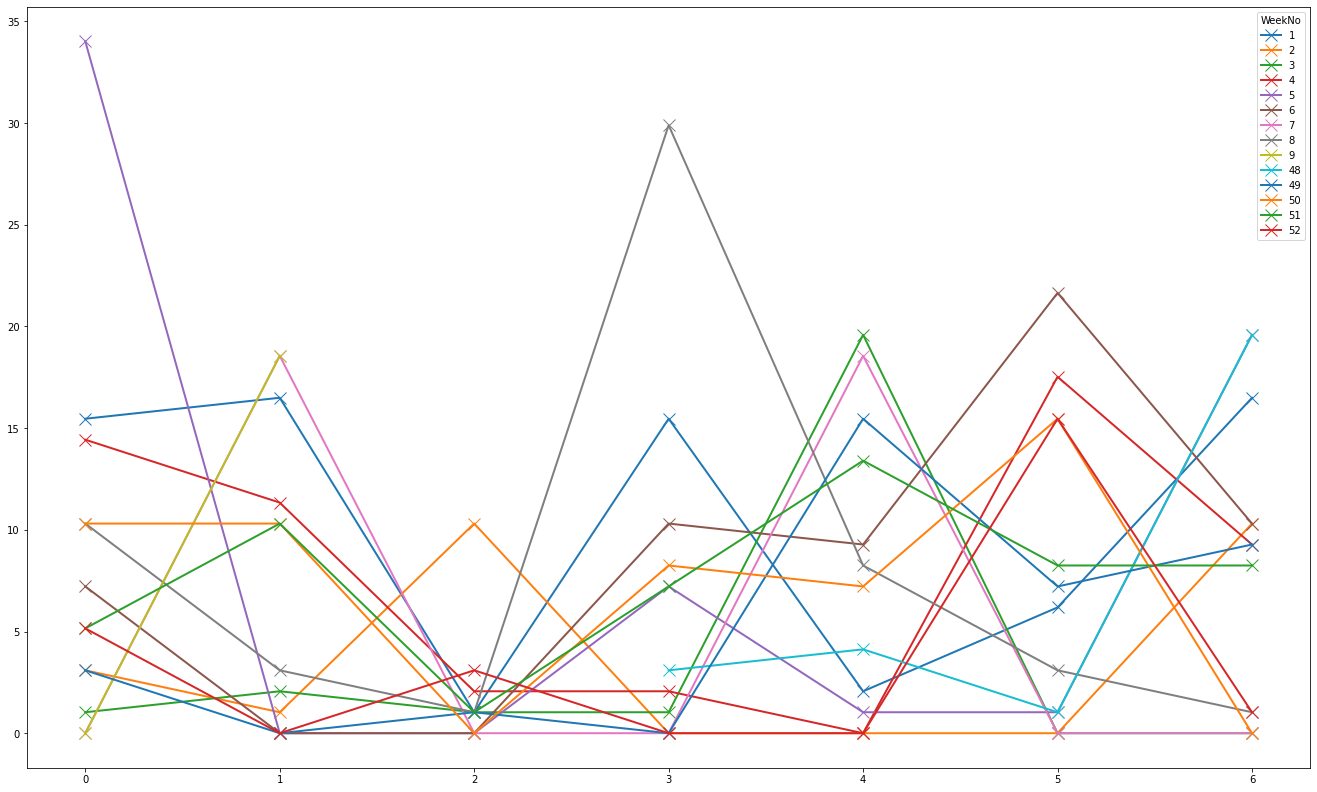

In [104]:
reshaped = (db_ego
            .assign(date=lambda f: pd.to_datetime(f.scheduled_departure))
            .assign(dayofweek=lambda f: f.scheduled_departure.dt.weekday, 
                    WeekNo=lambda f: f.scheduled_departure.dt.week)
            .assign(mean = lambda f: f.procent_free_seats)
            .set_index(['dayofweek', 'WeekNo'])
            .procent_free_seats
            .unstack()
            .reset_index(0, drop=True))

print(reshaped)

plt = reshaped.plot(marker='x', linewidth=2, markersize=12, figsize=(23,14))


А теперь посмотрим график средней загруженности самолетов по дням недели

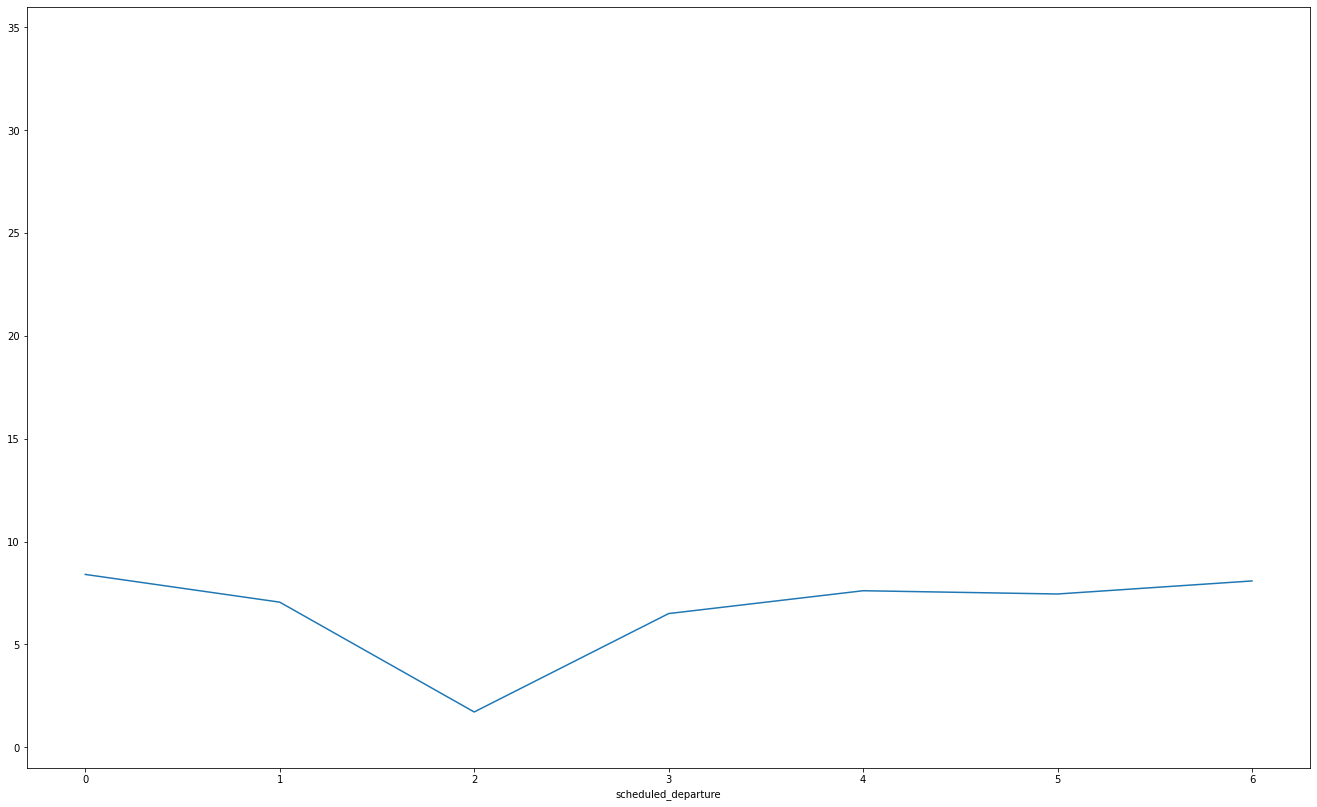

In [100]:
plt_mean = week_db_ego.procent_free_seats.plot(figsize=(23,14)).set_ylim(-1, 36)

Как видно из графиков, наибольшая наполняемость рейсов происходит по вторникам (1% свободных мест), а остальные дни составляет 7,5%.

Оценим прибыль по дням недели

/home/hotf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


WeekNo             1              2              3              4   \
0       582066.666667  696066.666667  708666.666667  600966.666667   
1       575766.666667  708666.666667  702366.666667  619866.666667   
2       708666.666667  651966.666667  708666.666667  702366.666667   
3       582666.666667  714966.666667  708666.666667  702366.666667   
4       689766.666667  714966.666667  544866.666667  714966.666667   
5       663966.666667  714966.666667  714966.666667  580866.666667   
6       588966.666667  639366.666667  714966.666667  645066.666667   

WeekNo             5              6              7              8   \
0       480666.666667  670866.666667  714966.666667  626766.666667   
1       714966.666667  714966.666667  575766.666667  696066.666667   
2       714966.666667  714966.666667  714966.666667  708666.666667   
3       670266.666667  614166.666667  714966.666667  480666.666667   
4       708666.666667  645666.666667  563166.666667  664566.666667   
5       696066.6666

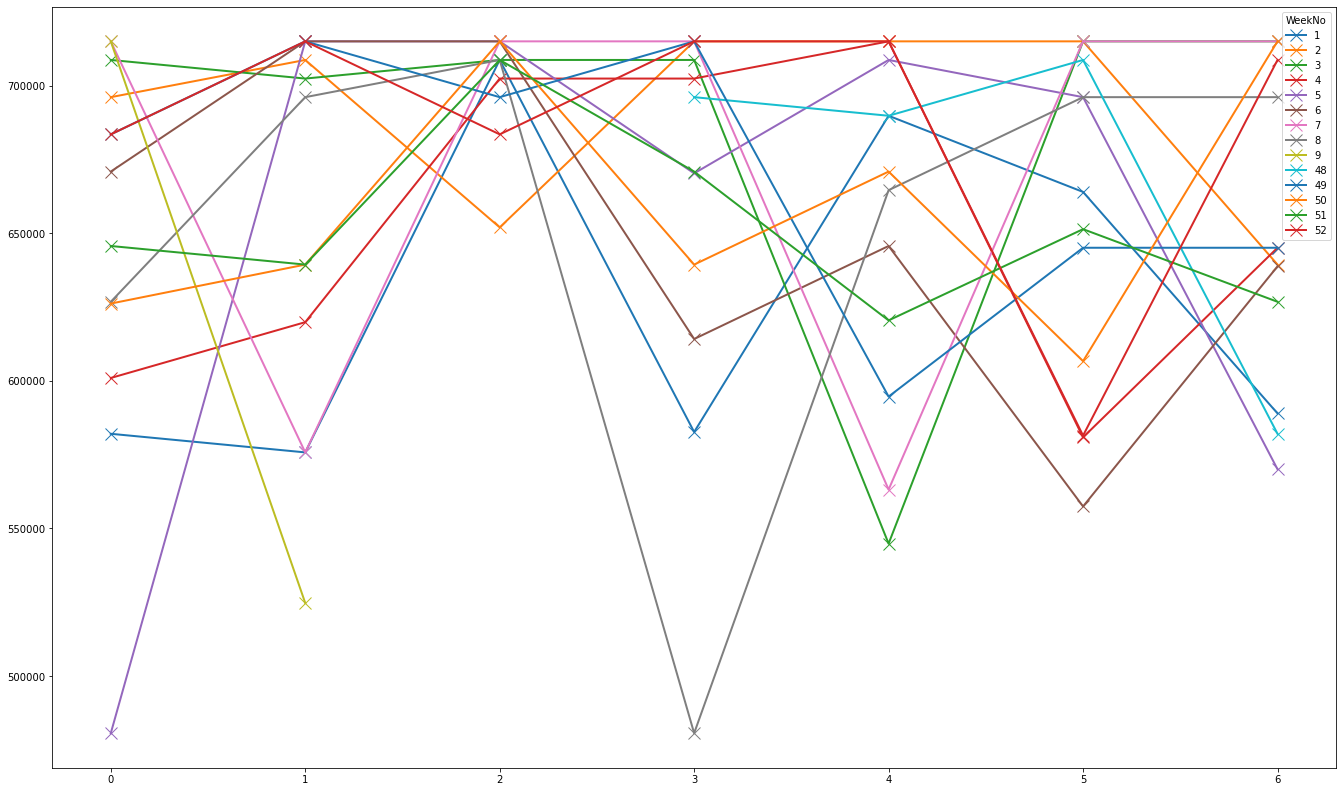

In [94]:
reshaped = (db_ego
            .assign(date=lambda f: pd.to_datetime(f.scheduled_departure))
            .assign(dayofweek=lambda f: f.scheduled_departure.dt.weekday, 
                    WeekNo=lambda f: f.scheduled_departure.dt.week)
            .assign(mean = lambda f: f.procent_free_seats)
            .set_index(['dayofweek', 'WeekNo'])
            .profit
            .unstack()
            .reset_index(0, drop=True))

print(reshaped)

plt = reshaped.plot(marker='x', linewidth=2, markersize=12, figsize=(23,14))


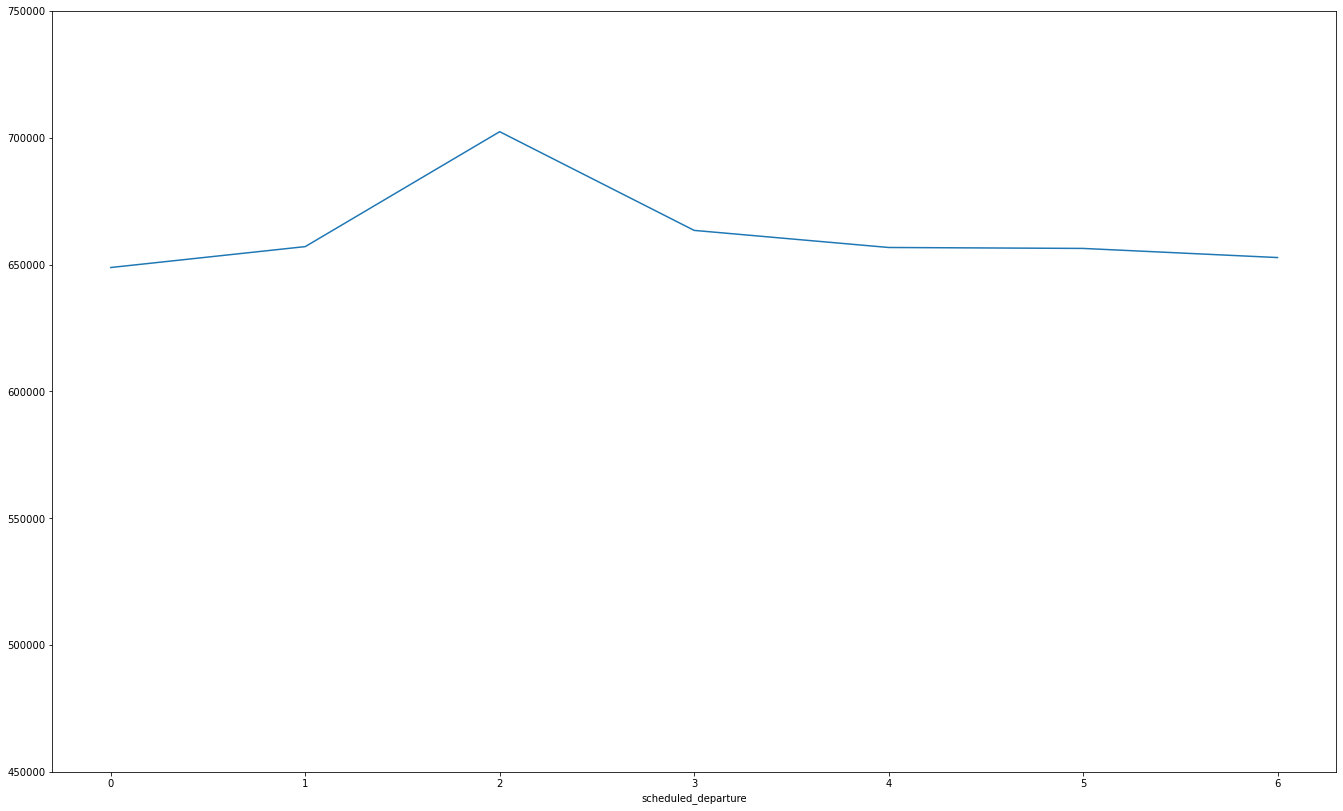

In [99]:
plt_mean = week_db_ego.profit.plot(figsize=(23,14)).set_ylim(450000, 750000)

Прибыль также напрямую связана с количеством пассажиров.

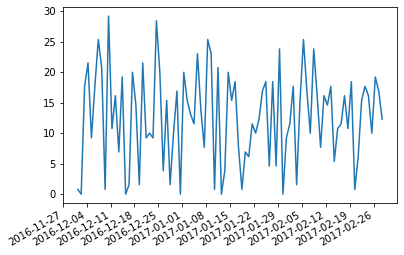

In [80]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.plot(db_svo.scheduled_departure, db_svo.procent_free_seats)
plt.gcf().autofmt_xdate()
plt.show()

In [50]:
db_svo['week_number'] = db_svo['scheduled_departure'].dt.week
db_svo['week_day'] = db_svo['scheduled_departure'].dt.weekday

/home/hotf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.
